## Table of Contents

1. **[Import Libraries](#import_lib)**
2. **[Functions](#set_options)**
3. **[Read Data](#Read_Data)**
4. **[Exploratory Data Analysis](#data_preparation)**
    - 4.1 - [Preparing the Dataset](#Data_Preparing)
        - 4.1.1 - [Data Dimension](#Data_Shape)
        - 4.1.2 - [Data Types](#Data_Types)
        - 4.1.3 - [Missing Values](#Missing_Values)
        - 4.1.4 - [Duplicate Data](#duplicate)
5. **[Target variable](#Data_Shape)**
6. **[Feature Engineering](#fea_sca)**
    - 6.1 - [Encoding](#cat_enc)
    - 6.2 - [Applying PCA](#fea_sca)
    - 6.3 - [Selecting Principal components](#split)
7. **[splitting data](#split)**
    - 7.1 - [Distribution of event in test and train](#split)
    - 7.2 - [Transforming data to PCA](#split)
8. **[Model building](#dec_tre)**
   - 8.1 - [Logistic Regression](#log_reg)   
   - 8.2 - [Random Forest Classifier](#log_reg)
        - 8.2.1 - [Base model](#log_reg)
        - 8.2.2 - [Feature importance](#dec_tre)
        - 8.2.3 - [Hyper parameter](#dec_tre)
        - 8.2.4 - [final light gbm model](#dec_tre)
   - 8.3 - [Adaboost Classifier](#log_reg)
        - 8.3.1 - [Base model](#log_reg)
        - 8.3.2 - [Hyper parameter](#dec_tre)
        - 8.3.3 - [final light gbm model](#dec_tre)
  - 8.4 - [GradientBoosting Classifier](#log_reg)
        - 8.4.1 - [Base model](#log_reg)
        - 8.4.2 - [Feature importance](#dec_tre)
        - 8.4.3 - [Hyper parameter](#dec_tre)
        - 8.4.4 - [final light gbm model](#dec_tre)
  - 8.5 - [XGBOOST Classifier](#dec_tre)
        - 8.5.1 - [base model](#dec_tre)
        - 8.5.2 - [Feature importance](#dec_tre)
        - 8.5.3 - [Hyper parameter](#dec_tre)
        - 8.5.4 - [final light gbm model](#dec_tre)
   - 8.6 - [Light GBM model](#dec_tre)
        - 8.6.1 - [base model](#dec_tre)
        - 8.6.2 - [Feature importance](#dec_tre)
        - 8.6.3 - [correlation](#correlation)
        - 8.6.4 - [vif](#dec_tre)
        - 8.6.5 - [Hyper parameter](#dec_tre)
        - 8.6.6 - [final light gbm model](#dec_tre)
9. **[Understanding industrial approach](#dec_tre)**  
   - 9.1 - [Metrics](#log_reg)
        - 9.1.1 - [Fill rate ](#log_reg)
        - 9.1.2 - [WOE and IV](#dec_tre)
   - 9.2 - [conversion raw to woe values](#log_reg)
   - 9.3 - [Correlation and VIF](#log_reg)
   - 9.4 - [Model evaluation](#log_reg)
        - 9.4.1 - [Scorecard](#log_reg)
        - 9.4.2 - [Ks table](#dec_tre)   
10. **[Conclusion](#conclu)**
11. **[Deployment](#deploy)**
12. **[References](#Refer)**

# 1. Import libraries

In [1]:
pip install xgboost

In [2]:
pip install imblearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_score 
from lightgbm import LGBMClassifier,plot_importance,plot_metric
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import metrics
from xgboost import XGBClassifier

# 2.Defining Functions

In [2]:
def scorecard(model,X_train,X_test):
    y_pred=model.predict(X_test)
    y_prob=model.predict_proba(X_test)[:,1]
    cc=confusion_matrix(y_test,y_pred)
    TN=cc[0,0]
    TP=cc[1,1]
    FP=cc[0,1]
    FN=cc[1,0]
    accuracy=(TP+TN)/(TP+TN+FP+FN)
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    Tpr=TP/(TP+FN)
    Fpr=FP/(FP+TN)
    f1_ratio=2*((recall*precision)/(precision+recall))
    auc_test=roc_auc_score(y_test,y_pred)
    y_pred_tr=model.predict(X_train)
    y_prob_tr=model.predict_proba(X_train)[:,1]
    cctrain=confusion_matrix(y_train,y_pred_tr)
    TN=cctrain[0,0]
    TP=cctrain[1,1]
    FP=cctrain[0,1]
    FN=cctrain[1,0]
    accuracy_tr=(TP+TN)/(TP+TN+FP+FN)
    precision_tr=TP/(TP+FP)
    recall_tr=TP/(TP+FN)
    Tpr_tr=TP/(TP+FN)
    Fpr_tr=FP/(FP+TN)
    f1_ratio_tr=2*((recall_tr*precision_tr)/(precision_tr+recall_tr))
    auc_tr=roc_auc_score(y_train,y_pred_tr)
    df=pd.DataFrame({'metrics':['accuracy','precision','recall','TPR','FPR','f1_ratio','auc_score'],
                     'train':[accuracy_tr,precision_tr,recall_tr,Tpr_tr,Fpr_tr,f1_ratio_tr,auc_tr],
                      'test':[accuracy,precision,recall,Tpr,Fpr,f1_ratio,auc_test]})
    df=df.set_index('metrics')
    return df        
        
    return df
def correlation(d,poscutoff,negcutoff):
    v1=[]
    v2=[]
    corr=[]
    for a in d.columns:
        for b in d.drop(labels=a,axis=1).columns:
            if d[a].corr(d[b])>poscutoff:
                v1.append(a)
                v2.append(b)
                corr.append(d[a].corr(d[b]))
            elif d[a].corr(d[b])<negcutoff:
                v1.append(a)
                v2.append(b)
                corr.append(d[a].corr(d[b]))
    df=pd.DataFrame({'v1':v1,'v2':v2,'corr':corr})
    
    return df
def plot_confusion_matrix(model):
    pred=model.predict(X_test_pca)
    cc=confusion_matrix(y_test,pred)
    plt.rcParams['figure.figsize']=(8,4)
    conf_matrix = pd.DataFrame(data = cc,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
    sns.heatmap(conf_matrix, annot= True, fmt = 'd', cmap ='Reds', cbar = False, linewidths = 0.1, annot_kws = {'size':25})
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()



# 3. Read data

In [3]:
data=pd.read_parquet('Project_data.parquet')
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_3014,var_3015,var_3016,var_3017,var_3018,var_3019,var_3020,var_3021,var_3022,Delay
0,-2.0,0.000000,-2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,10.0,8.0,6641.580000,8948.17,10106.0,10075.200,13919.200,14014.500,-24
1,-1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,10647.000000,10647.00,10647.0,31019.000,31019.000,31019.000,8
2,-1.0,0.000000,1.0,0.880797,0.0,0.0,0.0,0.0,0.0,0.0,...,49.0,49.0,28.0,0.000000,0.00,0.0,0.000,0.000,0.000,0
3,1.0,0.982014,-2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.083333,0.00,0.0,155.287,144.188,240.313,0
4,-2.0,0.000000,-2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5


# 4. Exploratory Data Analysis

# 4.1. Preparing data

# 4.1.1. data dimensions

In [4]:
print(' there are',data.shape[0],' rows and ',data.shape[1],' variables in the dataset')


 there are 11563  rows and  3023  variables in the dataset


# 4.1.2. data types

In [5]:
data.dtypes.value_counts()

float64    3004
int64        16
object        3
dtype: int64

there are 3004 float variables, 16 int variables and 4 categorical variables

# 4.1.3. Missing values

In [6]:
null=pd.Series(data.isnull().sum()/data.shape[0]*100)
var=null[null>=60].index
null.sort_values(ascending=False)

var_2268    100.0
var_2650    100.0
var_2649    100.0
var_2648    100.0
var_2647    100.0
            ...  
var_1562      0.0
var_1563      0.0
var_1564      0.0
var_1565      0.0
Delay         0.0
Length: 3023, dtype: float64

Dropping variables less than or equal  cutoff (i,e 60%)

In [7]:
data1=data.drop(labels=var,axis=1)
print('before drop',data.shape)
print('after drop', data1.shape)

before drop (11563, 3023)
after drop (11563, 3015)


In [15]:
# replacing all null values in variales with its median values
for var in data1.columns:
    if data1[var].dtype in ('int64','float64'):
        data1[var]=data1[var].fillna(data1[var].median())

In [16]:
data1.isnull().sum()

var_1       0
var_2       0
var_3       0
var_4       0
var_5       0
           ..
var_3019    0
var_3020    0
var_3021    0
var_3022    0
Delay       0
Length: 3015, dtype: int64

# 4.1.4. Duplicate records 

In [17]:
data2=data1.drop_duplicates()

In [18]:
print('before drop',data1.shape)
print('after drop', data2.shape)

before drop (11563, 3015)
after drop (11563, 3015)


as we can see there is no duplicate records in the dataset

# 5. Deciding target variable based on Delay 

target variable

Max_delay_all<=2 is non_event (good customer)

max_dela_all>=15 is event (bad customer)

rest are grey

In [19]:
target=[]
for i in range(len(data2)):
    if data2['Delay'].iloc[i]<=2:
        target.append('non event')
    elif data2['Delay'].iloc[i]>=15:
        target.append('event')
    else:
        target.append('grey')
        
data2['Event']=target

In [20]:
data2.Event.value_counts(normalize=True)*100

non event    77.609617
event        16.189570
grey          6.200813
Name: Event, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Event', ylabel='count'>

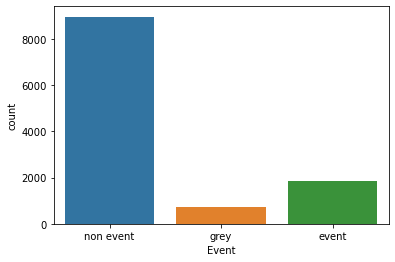

In [21]:
sns.countplot(data2.Event)

The above Event rate shows that there are only 6.2% of grey customers in the data so it does not help in classification of customers so dropping all grey customers

In [22]:
index_to_drop=data[data2.Event=='grey'].index
data3=data2.drop(index_to_drop)
print('before droping grey customer',data2.shape)
print('after droping grey customer',data3.shape)

before droping grey customer (11563, 3016)
after droping grey customer (10846, 3016)


In [23]:
data3=data3.drop(labels='Delay',axis=1)

# 6. Feature Engineering

# 6.1. Scaling Data and Encoding

In [24]:
dic={'non event':0,'event':1}
data3['Event']=data3['Event'].map(dic)

In [33]:
#scaling using standardscaler
data_cat=data3.select_dtypes(include=object)
data_num=data3.select_dtypes(include=np.number)
std=StandardScaler()
data_num_scaled=pd.DataFrame(std.fit_transform(data_num),columns=data_num.columns)
#encoding categorical variable
a=data_cat.columns
lb=LabelEncoder()
data_num_scaled[a[0]]=lb.fit_transform(data_cat[a[0]])
data_num_scaled.head()


,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_3015,var_3016,var_3017,var_3018,var_3019,var_3020,var_3021,var_3022,Event,var_2763
0,-1.334012,-1.015578,-1.195201,-0.448439,0.0,0.0,0.0,0.0,0.0,0.0,...,0.801373,1.660318,0.132189,0.178771,0.218508,0.223909,0.331410,0.318739,-0.45673,0
1,-0.524484,-1.015578,1.605019,2.760783,0.0,0.0,0.0,0.0,0.0,0.0,...,4.880897,6.364736,-0.074264,-0.070416,-0.071278,-0.134300,-0.143682,-0.146351,-0.45673,5
2,1.094572,1.341312,-1.195201,-0.448439,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.140056,-0.221449,-0.074261,-0.070416,-0.071278,-0.128779,-0.138761,-0.138376,-0.45673,5
3,-1.334012,-1.015578,-1.195201,-0.448439,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.244659,-0.221449,-0.074264,-0.070416,-0.071278,-0.131035,-0.140739,-0.144210,-0.45673,5
4,1.094572,1.098386,0.671612,1.373332,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.244659,-0.221449,-0.074264,-0.070416,-0.071278,-0.131603,-0.141093,-0.143834,-0.45673,5


# 6.2 Applying PCA to reduce number of features

In [53]:
pca=PCA(n_components=3014)
pca.fit(data_num_scaled)

PCA(n_components=3014)

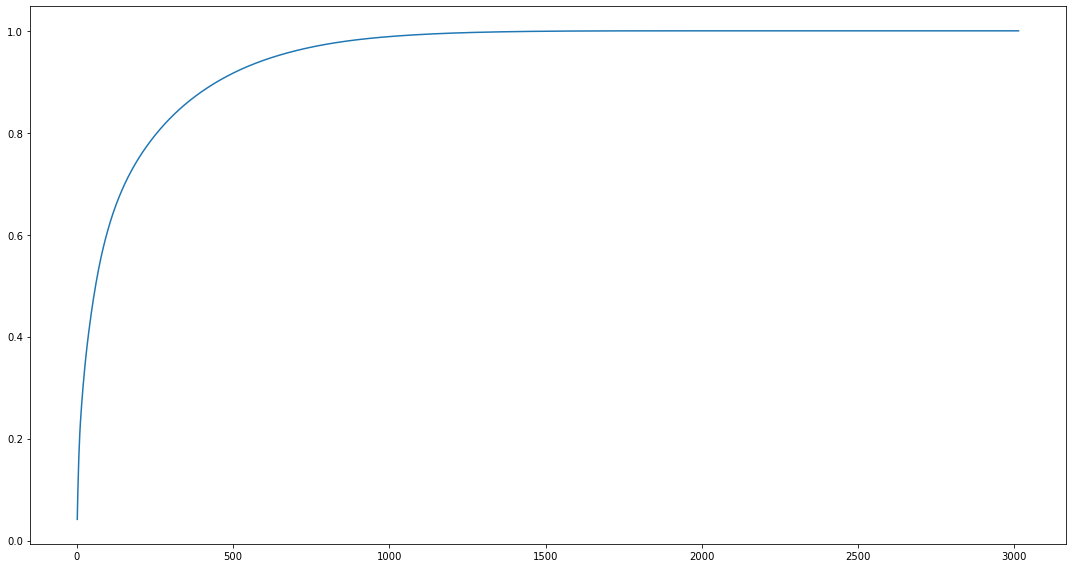

In [43]:
var=['Pc'+str(i) for i in range(1,3015)]
plt.rcParams['figure.figsize']=(15,8)
plt.plot(range(1,3015),np.cumsum(pca.explained_variance_ratio_))

In [54]:
np.cumsum(pca.explained_variance_ratio_)[1000:1040]

array([0.98875685, 0.98880587, 0.98885454, 0.98890313, 0.98895153,
       0.98899957, 0.98904752, 0.98909529, 0.98914284, 0.98919031,
       0.98923733, 0.9892842 , 0.98933099, 0.9893777 , 0.9894242 ,
       0.98947039, 0.98951655, 0.98956244, 0.9896082 , 0.98965364,
       0.98969891, 0.98974402, 0.98978893, 0.98983371, 0.98987845,
       0.98992299, 0.98996735, 0.99001141, 0.99005543, 0.99009922,
       0.99014271, 0.99018613, 0.99022937, 0.99027245, 0.99031545,
       0.99035837, 0.99040093, 0.99044339, 0.99048559, 0.9905277 ])

the above values shows that 99% of variation is covered by 1028 pcs 

# 6.3. Selecting Principal components

selecting 1028 principle components

In [55]:
pca=PCA(n_components=1028)
pca.fit(data_num_scaled)

PCA(n_components=1028)

# 7. Splitting data into train(80%) and test(20%)

In [56]:
X=data_num_scaled.drop(labels=['Event'],axis=1)
y=data3['Event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# 7.1 Checking for distribution of event rate i train and test

In [57]:
print('Y_train','\n',y_train.value_counts(normalize=True)*100)
print('Y_test','\n', y_test.value_counts(normalize=True)*100)

Y_train 
 0    82.745505
1    17.254495
Name: Event, dtype: float64
Y_test 
 0    82.718894
1    17.281106
Name: Event, dtype: float64


# 7.2 Transforming data to pca components

In [59]:
var=['Pc'+str(i) for i in range(1,1029)]
X_train_pca=pd.DataFrame(pca.fit_transform(X_train),columns=var)
X_test_pca=pd.DataFrame(pca.transform(X_test),columns=var)

# 8 MODEL BUILDING 

In [60]:
#defining a score card
score_card=pd.DataFrame(columns=['Model_Name','Accuracy(Train)','Accuracy(Test)','Diff_b/w_train&test(Acc)','AUC_Score'])
def update_score_card(model_name,model):
    global score_card
    train_pred = model.predict(X_train_pca)
    test_pred=model.predict(X_test_pca)
    y_pred_prob = model.predict_proba(X_test_pca)[:,1]
    score_card=score_card.append({'Model_Name': model_name,
                             'Accuracy(Train)': metrics.accuracy_score(y_train, train_pred),
                             'Accuracy(Test)':metrics.accuracy_score(y_test, test_pred),
                             'Diff_b/w_train&test(Acc)': abs(metrics.accuracy_score(y_train, train_pred)-metrics.accuracy_score(y_test, test_pred)),
                             'AUC_Score':metrics.roc_auc_score(y_test, y_pred_prob)},ignore_index=True)
    return score_card

# 8.1 Logistic Regression

In [61]:
Lr=LogisticRegression(C=10,solver='liblinear')
Lr.fit(X_train_pca,y_train)
lr_score=scorecard(Lr,X_train_pca,X_test_pca)
lr_score

,train,test
metrics,,
accuracy,0.878976,0.825806
precision,0.734523,0.493976
recall,0.467602,0.328000
TPR,0.467602,0.328000
FPR,0.035242,0.070195
f1_ratio,0.571429,0.394231
auc_score,0.716180,0.628903


1 : bad customer
0 : good customer


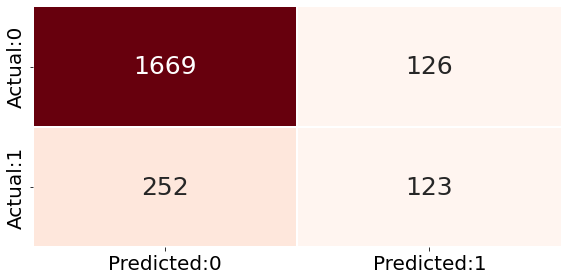

In [62]:
print(1,': bad customer')
print(0,': good customer')
plot_confusion_matrix(Lr)

Lr model is able to classify bad and good customer but we can see overfit is happening

In [63]:
score_card=update_score_card('Logistic Regression',Lr)
score_card

,Model_Name,Accuracy(Train),Accuracy(Test),Diff_b/w_train&test(Acc),AUC_Score
0,Logistic Regression,0.878976,0.825806,0.05317,0.756023


# 8.2. Random Forest Classifier

# 8.2.1 Base Model

In [64]:
rfc_base=RandomForestClassifier()
rfc_base.fit(X_train_pca,y_train)
rfc_base_score=scorecard(rfc_base,X_train_pca,X_test_pca)
rfc_base_score

,train,test
metrics,,
accuracy,0.999769,0.810138
precision,1.000000,0.088889
recall,0.998664,0.010667
TPR,0.998664,0.010667
FPR,0.000000,0.022841
f1_ratio,0.999332,0.019048
auc_score,0.999332,0.493913


The above model metrics shows that there is a large difference between train and test hence model is overfitting so trying hyper parameter tuning to reduce overfit

# 8.2.2 RFC feature importance

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


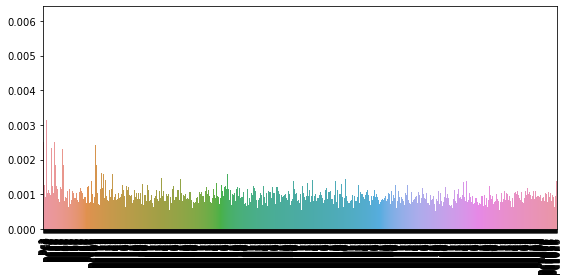

In [65]:
sns.barplot(X_test_pca.columns,rfc_base.feature_importances_)
plt.xticks(rotation=90);

In [68]:
imp=pd.DataFrame({'variables':X_test_pca.columns,'feature_imp':rfc_base.feature_importances_})
imp.head()

,variables,feature_imp
0,Pc1,0.004622
1,Pc2,0.002507
2,Pc3,0.001009
3,Pc4,0.001268
4,Pc5,0.000860


Here all the features has importance more than zero

1 : bad customer
0 : good customer


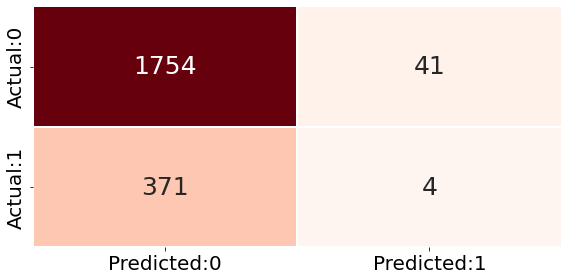

In [77]:
print(1,': bad customer')
print(0,': good customer')
plot_confusion_matrix(rfc_base)

# 8.1.3 Hyper parameter

In [79]:
param_test ={'min_samples_split':[10,50,100],
             'criterion' : ["gini", "entropy"],
       'max_depth':[4,8,12,16],'n_estimators':[100,150,200]
        }
grid=GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_test,scoring='f1')
grid.fit(X_test_pca,y_test)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 12, 16],
                         'min_samples_split': [10, 50, 100],
                         'n_estimators': [100, 150, 200]},
             scoring='f1')

In [80]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 16,
 'min_samples_split': 10,
 'n_estimators': 200}

# 8.2.4 Final RFC model

In [81]:
rfc_final=RandomForestClassifier(criterion='gini',max_depth=16,min_samples_split=10,n_estimators=200)
rfc_final.fit(X_train_pca,y_train)
rfc_final_score=scorecard(rfc_final,X_train_pca,X_test_pca)
rfc_final_score

,train,test
metrics,,
accuracy,0.947211,0.812903
precision,1.000000,0.121951
recall,0.694055,0.013333
TPR,0.694055,0.013333
FPR,0.000000,0.020056
f1_ratio,0.819401,0.024038
auc_score,0.847027,0.496639


1 : bad customer
0 : good customer


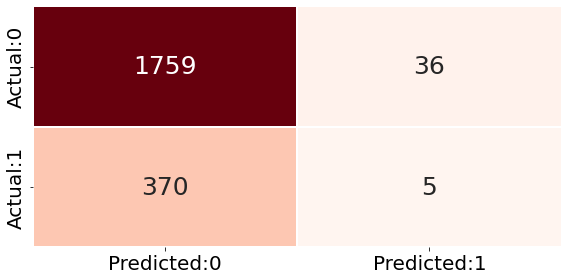

In [82]:
print(1,': bad customer')
print(0,': good customer')
plot_confusion_matrix(rfc_final)

The RFC model has good accuracy and it is not able to classify bad customers its predicting all customer as good customer so next trying boosting algorithm

In [83]:
score_card=update_score_card('RFC model',rfc_final)
score_card

,Model_Name,Accuracy(Train),Accuracy(Test),Diff_b/w_train&test(Acc),AUC_Score
0,Logistic Regression,0.878976,0.825806,0.053170,0.756023
1,RFC model,0.947211,0.812903,0.134307,0.620071


# 8.3. Adaboost Classifier

# 8.3.1 Base Model

In [84]:
ada_base=AdaBoostClassifier()
ada_base.fit(X_train_pca,y_train)
ada_base_score=scorecard(ada_base,X_train_pca,X_test_pca)
ada_base_score

,train,test
metrics,,
accuracy,0.838866,0.821198
precision,0.602484,0.442478
recall,0.194389,0.133333
TPR,0.194389,0.133333
FPR,0.026745,0.035097
f1_ratio,0.293939,0.204918
auc_score,0.583822,0.549118


The above adaboost model shows 82.7% accuracy but next trying hyper parameter tuning to improve performance

# 8.3.2 Hyper Parameter

In [85]:
tuning_parameters = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],'n_estimators' : [10,20,30,40,50]}
ada_model = AdaBoostClassifier()
ada_grid = GridSearchCV(estimator = ada_model, param_grid = tuning_parameters, cv = 3, scoring = 'accuracy')
ada_grid.fit(X_train_pca, y_train)
print('Best parameters for ADABoost classifier: ', ada_grid.best_params_, '\n')

Best parameters for ADABoost classifier:  {'learning_rate': 0.5, 'n_estimators': 50} 



# 8.2.3 Final ada boost model

In [87]:
ada_final=AdaBoostClassifier(learning_rate=0.5,n_estimators=50)
ada_final.fit(X_train_pca,y_train)
ada_final_score=scorecard(ada_final,X_train_pca,X_test_pca)
ada_final_score

,train,test
metrics,,
accuracy,0.831489,0.829032
precision,0.818182,0.600000
recall,0.030060,0.032000
TPR,0.030060,0.032000
FPR,0.001393,0.004457
f1_ratio,0.057990,0.060759
auc_score,0.514334,0.513772


the adaboost is giving good performance with hyper parameter so checking adboost base model performance with confusion matrix

1 : bad customer
0 : good customer


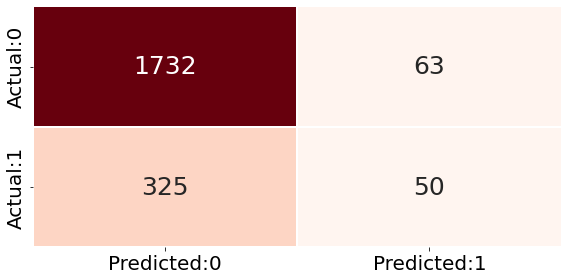

In [88]:
print(1,': bad customer')
print(0,': good customer')
plot_confusion_matrix(ada_base)

The adaboost base model is barely classifying bad customers so next trying with other boosting algorithms

In [ ]:
score_card=update_score_card('adaboost model',ada_base)
score_card

# 8.4 GradientBoosting Classifier

# 8.4.1 Base model

In [89]:
gbc=GradientBoostingClassifier()
gbc.fit(X_train_pca,y_train)
gbc_score=scorecard(gbc,X_train_pca,X_test_pca)
gbc_score

,train,test
metrics,,
accuracy,0.855694,0.822581
precision,0.972973,0.410714
recall,0.168337,0.061333
TPR,0.168337,0.061333
FPR,0.000975,0.018384
f1_ratio,0.287016,0.106729
auc_score,0.583681,0.521474


the model is giving good accuracy but it is not able to classify bad customers

# 8.4.2 Hyper parameter

In [ ]:
tuning_parameters = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],'n_estimators':[30, 50, 70, 90],
                     'max_depth': [2,6,10],'min_samples_split': [2,6,10],
                     'min_samples_leaf': [2,6,10]}
gboost_model = GradientBoostingClassifier()
gb_grid = GridSearchCV(estimator = gboost_model, param_grid = tuning_parameters, cv = 3, scoring = 'accuracy')
gb_grid.fit(X_train_pca, y_train) 

In [ ]:
print('Best parameters for GBoost classifier: ', gb_grid.best_params_, '\n')  

# 8.4.3 Final model

In [90]:
gbc_final=GradientBoostingClassifier(learning_rate=0.1,max_depth=6,min_samples_leaf=10,min_samples_split=10,n_estimators=30)
gbc_final.fit(X_train_pca,y_train)
gbc_final_score=scorecard(gbc_final,X_train_pca,X_test_pca)
gbc_final_score

,train,test
metrics,,
accuracy,0.903873,0.829032
precision,1.000000,0.566667
recall,0.442886,0.045333
TPR,0.442886,0.045333
FPR,0.000000,0.007242
f1_ratio,0.613889,0.083951
auc_score,0.721443,0.519045


1 : bad customer
0 : good customer


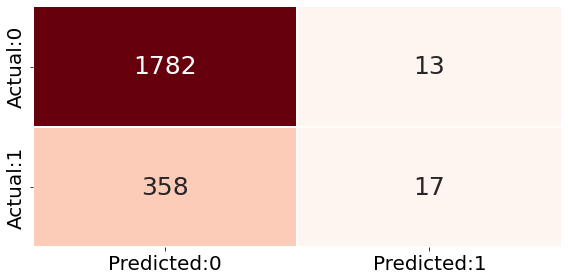

In [91]:
print(1,': bad customer')
print(0,': good customer')
plot_confusion_matrix(gbc_final)

The gbc model also has good accuracy but it is not classying bad customers, it has classified only 2 customer as bad

# 8.5 XGBOOST CLASSIFIER

# 8.5.1 Base model

In [92]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_pca, y_train)
xgb_score=scorecard(xgb_model,X_train_pca,X_test_pca)
xgb_score

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,train,test
metrics,,
accuracy,0.999885,0.829493
precision,1.000000,0.540984
recall,0.999332,0.088000
TPR,0.999332,0.088000
FPR,0.000000,0.015599
f1_ratio,0.999666,0.151376
auc_score,0.999666,0.536201


1 : bad customer
0 : good customer


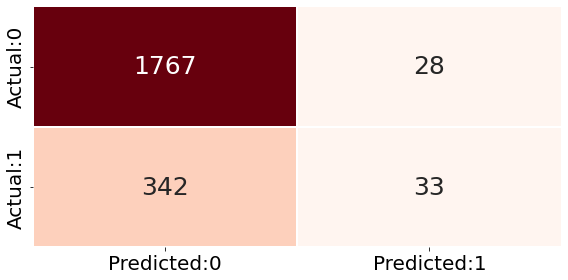

In [93]:
print(1,': bad customer')
print(0,': good customer')
plot_confusion_matrix(xgb_model)

the XGB model is able to classify bad customers compared to previous model but it is overfitting so trying hyper parameter tuning to reduce overfit

# 8.5.2 Hyper parameter

In [95]:
tuning_parameters = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                     'max_depth': [1,3,5,7,9],
                     'gamma': [0, 1, 2, 3, 4]}
xgb_model = XGBClassifier()
xgb_grid = GridSearchCV(estimator = xgb_model, param_grid = tuning_parameters, cv = 3, scoring = 'accuracy',verbose=0)
xgb_grid.fit(X_train_pca, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:24:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:26:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:27:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:29:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:42:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:20:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:23:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:28:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:29:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:30:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:34:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:40:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:43:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:54:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:01:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:05:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:09:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:09:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:12:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:19:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:25:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:28:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [96]:
print('Best parameters for XGBoost classifier: ', xgb_grid.best_params_, '\n')

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# 8.5.3 Final xgb model

In [99]:
xgb_final = XGBClassifier(gamma=1,learning_rate=0.1,max_depth=8)
xgb_final.fit(X_train_pca, y_train)
xgb_score=scorecard(xgb_final,X_train_pca,X_test_pca)
xgb_score

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:39:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,train,test
metrics,,
accuracy,0.999885,0.829493
precision,1.000000,0.580645
recall,0.999332,0.048000
TPR,0.999332,0.048000
FPR,0.000000,0.007242
f1_ratio,0.999666,0.088670
auc_score,0.999666,0.520379


1 : bad customer
0 : good customer


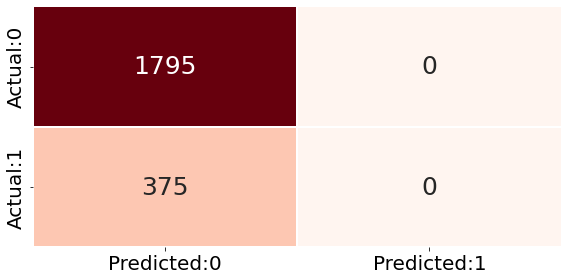

In [98]:
print(1,': bad customer')
print(0,': good customer')
plot_confusion_matrix(xgb_final)

The xgb model with hyper parameters overfit is reduced but the model is calssifying all customers as good

# 8.6 LightGBM

# 8.6.1 Base Model

In [ ]:
lgbm1=LGBMClassifier()
lgbm1.fit(X_train_pca,y_train)
lgbm1_score=scorecard(lgbm1,X_train_pca,X_test_pca)
lgbm1_score

In [ ]:
print(1,': bad customer')
print(0,': good customer')
plot_confusion_matrix(lgbm1)

the lgbm model is classifying bad customers and still need to improve and reduce overfitting

# 8.6.2 droping variables Which has zero feature importance 

In [ ]:
plot_importance(lgbm1)

In [ ]:
imp=pd.DataFrame({'variables':X_train_pca.columns,'importance':lgbm1.feature_importances_})
imp

The above plot shows that all the pcs have importance in the model

# 8.6.3 Checking for correlation between variables

if the correlation is high between two variables then both the variables will give same meaning or influence on target variable. so we can drop one of them this will reduce complexity of model as well as chance of overfitting. 

In [ ]:
corr=correlation(X_train_pca,0.65,-0.65)
corr

The variables does not have high correlation

# 8.6.4 Checking for vif values of variables

if vif is high then variables are highly correlated with each other this leads to the overfitting of model. to avoid overfitting we remove variables having vif values.

Considering variables with vif less than or equal to 10


In [ ]:
z=X_train_pca.fillna(0)
vif_data = pd.DataFrame()
vif_data["feature"] = z.columns
vif_data["VIF"] = [variance_inflation_factor(z.values, i)
                          for i in range(len(z.columns))]

In [ ]:
vif_data.max()

The variables does not have vif values >1.0

# 8.6.5 Hyper parameter

Checking for the parameter which gives best result

In [ ]:
param={'boosting_type':['dart','gbdt',],
       'max_depth':[4,8,12],'n_estimators':[75,100,150,200],
       'min_child_samples':[300,400,450,500,550]
        }
grid=GridSearchCV(estimator=LGBMClassifier(),param_grid=param,cv=2,scoring='accuracy')
grid.fit(X_train_pca,y_train)

In [ ]:
print('Best params','\n',grid.best_params_)

# 8.5.6 Final Model by best parameter

In [ ]:
lgbm4=LGBMClassifier(min_child_samples=450,max_depth=8,n_estimators=75,boosting_type='gbdt')
lgbm4.fit(X_train_pca,y_train)
lgbm_score=scorecard(lgbm4,X_train_pca,X_test_pca)
lgbm_score

the above model metrics shows that overfitting is reduced

In [ ]:
print(1,': bad customer')
print(0,': good customer')
plot_confusion_matrix(lgbm4)

The lgbm model is classifying the bad customer barely but it is good compared to others

# Next

By observing all the model performance we can see the models are giving good accuracy but not able to classify customers properly. and there is conversion of data into PC components this approach will be difficulty in deploying the model so next trying industrial approaches to build a model and evaluate a model.

# 9 Understanding industrial approach

# 9.1 Metrics

Defining a functions to calculate all metrics and trying on a trial data

In [ ]:
trial_data=data3.iloc[0:100,0:20]
trial_data['Event']=data3['Event'].iloc[0:100]
trial_data

# 9.1.1 Fill Rate analysis 

Fill rate : ratio of number of non null data points to the total number of data points.
    
Fill rate is useful for the Feature selection, because fill rate tells how much percentage of data a particular variable has.

defining a function and trying it on trial data


In [ ]:
def fillrate(df):
    data=pd.DataFrame(columns=['variable','unique_values','count','mean','median','mode','max','min',
                               'fill rate'])
    for var in df.columns:
        if ((df[var].dtype!='object') and (df[var].dtype!='datetime64[ns]')):
            fill_rate=np.round((1-(df[var].isnull().sum()/len(df[var])))*100,3)
            data=data.append({'variable':var,'unique_values':len(df[var].value_counts()),'count':len(df[var]),
                         'mean':np.round(df[var].mean(),3),'median':np.round(df[var].median(),3),'mode':np.NAN,'max':df[var].max(),
                          'min':df[var].min(),'fill rate':fill_rate},ignore_index=True)
        else:
            fill_rate=np.round((1-(df[var].isnull().sum()/len(df[var])))*100,3)
            data=data.append({'variable':var,'unique_values':len(df[var].value_counts()),'count':len(df[var]),
                         'mean':np.NAN,'median':np.NAN,'mode':df[var].mode()[0],'max':np.NAN,
                          'min':np.NAN,'fill rate':fill_rate},ignore_index=True)                      

    return data

In [ ]:
# fill rate for all variables in trial data
df_fr=fillrate(trial_data)
df_fr.head()

# 9.1.2 WOE (Weight of evidence)  & IV (Information Value)

WOE  (Weight of Evaluation) : the WOE tells the predictive power of an independent variable in relation to dependent variable. or it measure of seperation of good and bad customers.

                                 WOE = In(% of non-events ➗ % of events)


IV (Information value) : Information value is the single value representing the entire features predictive power. This will be useful during the feature selection.  

                                 IV = ∑ (% of non-events - % of events) * WOE
                                 
based on IV values we can select Variables with higher information


Defining a function to calculate Woe and Iv for all the variables

In [ ]:
def iv_woe(data, target, bins=10):
    
    newDF = pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] =np.maximum(d['Events'],1) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'],1) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        if ivars=='var_1':
            a=d
        
    return newDF,a

In [ ]:
df,a=iv_woe(trial_data,target='Event')

In [ ]:
# Example table for woe and iv calculation for a single variable i,e var_1
print('IV value for var_1 is ',a.IV.sum())
a

In [ ]:
#Iv values for all variables 
df.head()

# 9.2 Converting raw data to woe values

The variables in the dataset has a different scales (eg, var1 has values 0 to 1 but var2 has 1000 to 50000), so the raw data is replaced by woe values (with corresponding woe bins) now the variables in the dataset are almost in a same scale. now the training of model will be better without any misleading in learning of model. 


In [ ]:
# defining function to replace raw data by woe values
def raw_to_woe_values(data, target, bins=10):
    
    df = data.copy()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': target})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': target})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] =np.maximum(d['Events'],1) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'],1) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        z=list(d['Cutoff'])
        j=list(d['WoE'])
        dic={z[i]:j[i] for i in range(len(d))}
        df[ivars]=d0['x'].map(dic)       
    return df

In [ ]:
a

In [ ]:
y=trial_data['Event']
df_woe=raw_to_woe_values(trial_data,y)
df_woe.head()

the above user defined function able to replace entire data with woe values succesfully

# 9.3 Correlation and VIF

CORRELATION  between independent variables is very important to reduce multicollinearity or overfitting, if the correlation is high between two variables then both the variables will give same meaning or influence on target variable.

so we can drop one of them this will reduce complexity of model as well as chance of overfitting. 

VIF value tells about the multicollinearity between variables. if vif is high then variables are highly correlated with each other this leads to the overfitting of model. to avoid overfitting we remove variables having vif values.

vif is useful to reduce multicollinearity of model.


In [ ]:
# defining function to return all variables with correlation > cutoff
def correlation(d,poscutoff,negcutoff):
    v1=[]
    v2=[]
    corr=[]
    for a in d.columns:
        for b in d.drop(labels=a,axis=1).columns:
            if d[a].corr(d[b])>poscutoff:
                v1.append(a)
                v2.append(b)
                corr.append(d[a].corr(d[b]))
            elif d[a].corr(d[b])<negcutoff:
                v1.append(a)
                v2.append(b)
                corr.append(d[a].corr(d[b]))
    df=pd.DataFrame({'v1':v1,'v2':v2,'corr':corr})    
    return df

In [ ]:
df_corr=correlation(trial_data,0.85,-0.85)
df_corr.head()

In [ ]:
# defining a function to return vif value for each variable
def VIf_value(data):
    z=data
    vif_data = pd.DataFrame()
    vif_data["feature"] = z.columns
    vif_data["VIF"] = [variance_inflation_factor(z.values, i) for i in range(len(z.columns))]
    vif_data=vif_data.set_index('feature')
    return vif_data    

In [ ]:
df_vif=VIf_value(trial_data)
df_vif.head()

# 9.4 model evaluation metrics

# 9.4.1 Scorecard

In [ ]:
# defining function to return all model metrics
def scorecard(model,X_train,X_test):
    y_pred=model.predict(X_test)
    y_prob=model.predict_proba(X_test)[:,1]
    cc=confusion_matrix(y_test,y_pred)
    TN=cc[0,0]
    TP=cc[1,1]
    FP=cc[0,1]
    FN=cc[1,0]
    accuracy=(TP+TN)/(TP+TN+FP+FN)
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    Tpr=TP/(TP+FN)
    Fpr=FP/(FP+TN)
    f1_ratio=2*((recall*precision)/(precision+recall))
    auc_test=roc_auc_score(y_test,y_pred)
    a,ks_test=ks(model,X_test,y_test)
    y_pred_tr=model.predict(X_train)
    y_prob_tr=model.predict_proba(X_train)[:,1]
    cctrain=confusion_matrix(y_train,y_pred_tr)
    TN=cctrain[0,0]
    TP=cctrain[1,1]
    FP=cctrain[0,1]
    FN=cctrain[1,0]
    accuracy_tr=(TP+TN)/(TP+TN+FP+FN)
    precision_tr=TP/(TP+FP)
    recall_tr=TP/(TP+FN)
    Tpr_tr=TP/(TP+FN)
    Fpr_tr=FP/(FP+TN)
    f1_ratio_tr=2*((recall_tr*precision_tr)/(precision_tr+recall_tr))
    auc_tr=roc_auc_score(y_train,y_pred_tr)
    a,ks_train=ks(model,X_train,y_train)
    df=pd.DataFrame({'metrics':['accuracy','precision','recall','TPR','FPR','f1_ratio','auc_score','ks statistics'],
                     'train':[accuracy_tr,precision_tr,recall_tr,Tpr_tr,Fpr_tr,f1_ratio_tr,auc_tr,ks_train],
                      'test':[accuracy,precision,recall,Tpr,Fpr,f1_ratio,auc_test,ks_test]})
    df=df.set_index('metrics')
    return df

In [ ]:
X=trial_data.drop(labels=['Event'],axis=1)
y=trial_data['Event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
lr=LogisticRegression()
lr.fit(X_train,y_train)

In [ ]:
lr_score=scorecard(lr,X_train,X_test)
lr_score

# 9.4.2 Ks table

KS Statistics : Measure the Discriminatory power of a model.

it is the maximum difference between distribution of cumulative events and cumulative non events.

good ks statistics value is between 40 to 70

if value is greater than 70 than model is overfitting


In [ ]:
# defining function to create Ks table for a given model
def ks(model,X_test,y_test):
    y_prob=model.predict_proba(X_test)[:,1]
    data=pd.DataFrame({'target':y_test,'prob':y_prob})    
    data['target0'] = 1 - data['target']
    data['bucket'] = pd.qcut(data['prob'], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['prob']
    kstable['max_prob'] = grouped.max()['prob']
    kstable['events']   = grouped.sum()['target']
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data['target'].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data['target'].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    ks=np.round(kstable.KS.max(),2)
    return kstable,ks


In [ ]:
ks_table,ks_value=ks(lr,X_train,y_train)
print('ks value of lr model is ',ks_value)

In [ ]:
ks_table